# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [45]:
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [46]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
import nltk
nltk.download('brown')
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict
import spacy.cli

import en_core_web_sm
nlp = en_core_web_sm.load()

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\tarad\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [47]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [48]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [49]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        # fetch and clean text
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [50]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

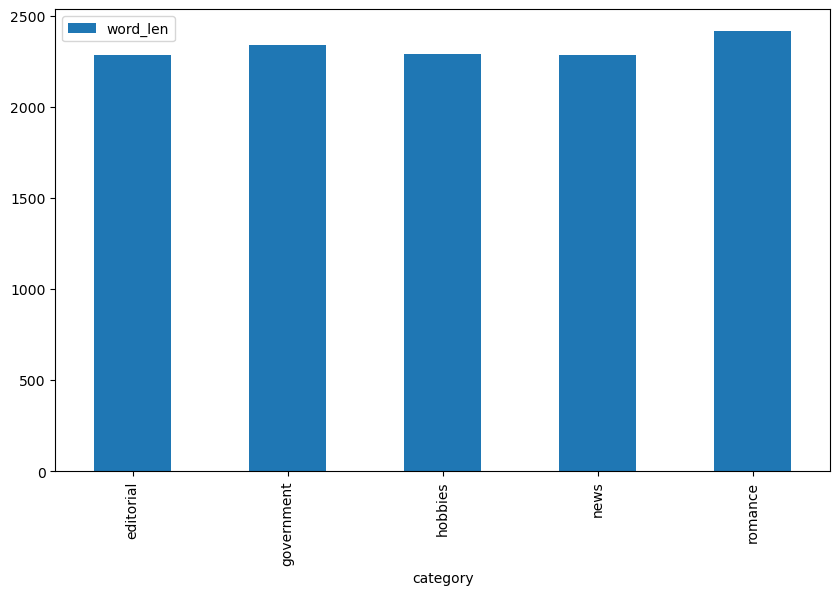

In [51]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [52]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\tarad\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [53]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The count_text_vectors data frame holds the term frequency, which indicates how often each word appears in each document. The values in this matrix are the raw counts of each word within the documents. On the other hand, tfidf_text_vectors holds the term frequency-inverse document frequency (TF-IDF) values for each word in the document. These values represent the importance of a word in a document relative to how common that word is across the entire corpus. Words that appear frequently across many documents are down-weighted, while more rare or unique words in a specific document are given higher importance. Both matrices represent 166 documents and 4941 unique terms.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [54]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [55]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [56]:
# Your code here
# Assign each document to the topic with the highest score in W_text_matrix
df['nmf_topic'] = np.argmax(W_text_matrix, axis=1)

# View the topic assignments
df[['id', 'category', 'nmf_topic']].head()

,id,category,nmf_topic
0,cb01,editorial,2
1,cb02,editorial,0
2,cb03,editorial,0
3,cb04,editorial,0
4,cb05,editorial,0


In [57]:
# Tally the Brown categories for each NMF topic
topic_category_tally = pd.crosstab(df['nmf_topic'], df['category'])

# Display the tally
print(topic_category_tally)

category   editorial  government  hobbies  news  romance
nmf_topic                                               
0                 20           4        0     8        0
1                  4           0        8     0       29
2                  2          26       26    11        0
3                  0           0        1    17        0
4                  1           0        1     8        0


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The five-topic NMF model shows partial alighnment to the original Brown categories. Topic 0 is mostly "editorial" but also has "news". Topic 1 is dominated by "romance" and some "hobbies". Topic 2 combines "government" and "hobbies" with some "news". Topic 3 is strongly linked to "news". Last, Topic 4 is a mmix of severral categories with no clear alignment. So, while some topics aligned well with the original categgores, others blend multiple categories, indicating that the NMF model captures broader themes that overlap across categories. 

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [58]:
# Your code here
# Fit an LSA model with 5 components
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
W_lsa_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
H_lsa_matrix = lsa_text_model.components_

# Assign each document to the topic with the highest score in W_lsa_matrix
df['lsa_topic'] = np.argmax(W_lsa_matrix, axis=1)

# View the LSA topic assignments for the first few documents
df[['id', 'category', 'lsa_topic']].head()

# Tally the Brown categories for each LSA topic
lsa_topic_category_tally = pd.crosstab(df['lsa_topic'], df['category'])

# Display the tally
print(lsa_topic_category_tally)

category   editorial  government  hobbies  news  romance
lsa_topic                                               
0                 27          30       36    34       21
1                  0           0        0     0        8
3                  0           0        0     3        0
4                  0           0        0     7        0


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The five-topic LSA model shows significant overlap across multiple categories. Topic 0 covers a broad range of categories, including "editorial," "government," "hobbies," "news," and "romance," indicating that it captures a mix of themes. Topic 1 focuses mostly on "romance," while Topics 3 and 4 are sparse, pulling only a few documents in "news." The LSA model blends content from different categorie. This indicates that it captures broader themes rather than aligning with the original Brown categories.

In [59]:
# call display_topics on your model to view the top terms per topic
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: The display topics output shows the most important terms for each LSA topic, offering insights into the main themes. Topic 00 has dialogue words like "said," "mr," and "mrs," suggesting content related to conversations or narratives. Topic 01 includes conversational terms such as "said," "didn," and "thought," which could represnt romance (as seen in lsa model), but in general conversations. Topic 02 focuses on names like "mrs," "mr," and political figures like "kennedy" and "khrushchev," which points to more political/formal content. Topic 03 is heavily skewed towards terms like "mrs," "club," and "game," possibly indicating social or recreational themes. Last, Topic 04 is related to sports with terms like "game," "league," "baseball," and "team." Overall, the topics capture distinct but broad themes, with some overlap across categories.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [60]:
# Fit your LDA model here
lda_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_model.fit(count_text_vectors)

# Assign each document to the topic with the highest score in the LDA model
doc_topic_distr = lda_model.transform(count_text_vectors)
df['lda_topic'] = np.argmax(doc_topic_distr, axis=1)

# View the LDA topic assignments for the first few documents
print(df[['id', 'category', 'lda_topic']].head())

# Tally the Brown categories for each LDA topic
lda_topic_category_tally = pd.crosstab(df['lda_topic'], df['category'])

# Display the tally
print(lda_topic_category_tally)


     id   category  lda_topic
0  cb01  editorial          2
1  cb02  editorial          2
2  cb03  editorial          2
3  cb04  editorial          2
4  cb05  editorial          2
category   editorial  government  hobbies  news  romance
lda_topic                                               
0                  3           1       11     4       28
1                  1          12        9     3        0
2                 21           3        2    32        1
3                  2           4        8     3        0
4                  0          10        6     2        0


In [61]:
# Call `display_topics` on your fitted model here
# Display the top terms in each topic
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display topics
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())

Topic 0:
said mrs little good way don ll old man thought
Topic 1:
state development 000 program business system sales small use 1960
Topic 2:
said mr president city state american john week home world
Topic 3:
feed college general university work president student students members schools
Topic 4:
states state united shall government tax fiscal department act class


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model shows thematic divisions. Topic 0 is narrative-driven, with conversational words like "said" and "mrs," likely linked to fiction or personal stories. Topic 1 focuses on business and governmental terms like "development" and "program," while Topic 2 is more political, with terms like "president" and "city." Topic 3 highlights education with words like "college" and "university," and Topic 4 centers around government and law with terms like "tax" and "department." These topics reflect broad, recognizable themes.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Topic 0 aligns closely with the "romance" category, capturing fiction-related content. Topic 1 is associated with "government" and "hobbies," reflecting business and governmental discussions. Topic 2 matches well with "editorial" and "news," focusing on political commentary. Topic 3 blends "hobbies" and "education," suggesting academic content, while Topic 4 is linked to "government" documents. Overall, the LDA model aligns well with some categories but also mixes documents across multiple categories, capturing broader themes.

In [62]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [63]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Through this visualization you can see the relations between topics and their associated terms. In the intertopic distance map (princiapl component scatter plot), the bubbles show the different topics. The size of them indicates the portion of the odcument each topic covers. Topic 3 has the largest distribution, suggesting it dominates a signficant portion of the documents. The spatial arragement of the topics shows the distances between them. Topics that are further apart like topics 1 adn 3 are less similar in terms of the words they use while topics like 2 and 4, are closer together and share more vocabulary.

The Salient Terms graph show the top 30 most relevant terms for each topic. In Topic 3, terms like "president", "city", and state suggest a gocus on more political thhemes. On the other hand, Topioc 1 includes words like  "said," "mrs," and "little," pointing towards more conversational or narrative themes. The length of the bars indicaate the overall frequency of each othe terms, while the red shading indicates how strong a term is associated with  particular topic.

All together, the visualization shows that the LDA model has successfully identified distinct themes. Topics like Topic 3 and Topic 1 have minimal overlap, indicating clear differentiation, while others have more shared vocabulary, as seen in their distance on the scatterplot. The salient terms graph further underscores the dominant concepts driving each topic, offering a clear understanding of the themes within the corpus.
